**From a series of application of modern interpolation methods for economics: written by [Mahdi E Kahou](https://sites.google.com/site/mahdiebrahimikahou/about-me)**

This code is for generating the plots and animations.

The explanation and main code can be found in this [Notebook](https://github.com/Mekahou/Notes/blob/main/deep_learning/McCall_DL.ipynb).

In [1]:
# Importing packages

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib import cm

# For closed-form solution
from scipy.integrate import quad
from scipy.optimize import fsolve

In [3]:
fontsize= 14
ticksize = 14
figsize = (8, 6)
params_fig = {'font.family':'serif',
    "figure.figsize":figsize,
    'figure.dpi': 80,
    'figure.edgecolor': 'k',
    'font.size': fontsize,
    'axes.labelsize': fontsize,
    'axes.titlesize': fontsize,
    'xtick.labelsize': ticksize,
    'ytick.labelsize': ticksize
}
plt.rcParams.update(params_fig)

## Closed form solution

In [4]:
B = 0.5
c = 0.05
β = 0.9

In [5]:
## PDF of wages uniformly distributed on [0, B]
f = lambda w: 1/B if 0 <= w <= B else 0

In [6]:
def indifference(w):
    LHS = w-c
    integrand = lambda z: (z - w) * f(z)
    integral, error = quad(integrand, w, B)
    
    RHS = (β/(1-β))* integral
    return LHS-RHS

In [7]:
## finiding w_bar

In [8]:
w_bar = fsolve(indifference, x0=0.5)[0]

In [9]:
## closed-form value function 

In [10]:
def v_theory(w):
    reject_value = w_bar/(1-β)
    accept_value = w/(1-β)
    index = (w> w_bar)*1.0
    return (index*accept_value)+ ((1-index)*reject_value)

## Deep learning solution

In [11]:
# defining the neural network

In [12]:
class NN(nn.Module):
    def __init__(self,
                 dim_hidden = 128,
                layers = 2,
                hidden_bias = True):
        super().__init__()
        self.dim_hidden= dim_hidden
        self.layers = layers
        self.hidden_bias = hidden_bias

        torch.manual_seed(123)
        module = []
        module.append(nn.Linear(1,self.dim_hidden, bias = self.hidden_bias))
        module.append(nn.ReLU())

        for i in range(self.layers-1):
            module.append(nn.Linear(self.dim_hidden,self.dim_hidden, bias = self.hidden_bias))
            module.append(nn.Tanh())

        module.append(nn.Linear(self.dim_hidden,1))
        #module.append(nn.Softplus(beta = 1.0)) #The softplus layer ensures c>0,k>0

        self.q = nn.Sequential(*module)


    def forward(self, x):
        out = self.q(x) # first element is consumption, the second element is capital
        return  out

In [13]:
def E_v(model,a,b,n):
    # model: the neural network (or any callable)
    # a: lower bound of the unifrom distribution
    # b: upper bound of the uniform distribution
    # n: number of the nodes Gauss-legendre quadrature
    nodes, weights = np.polynomial.legendre.leggauss(n)
    nodes_tensor = torch.tensor(nodes, dtype=torch.float32).unsqueeze(-1)
    weights_tensor = torch.tensor(weights, dtype=torch.float32).unsqueeze(-1)
    adjusted_nodes = ((b - a) / 2) * nodes_tensor + ((a + b) / 2)
    integral = ((b - a) / 2) * torch.sum(weights_tensor * model(adjusted_nodes))
    expectation = integral/(b-a)
    return expectation

In [14]:
# defining the training data and data-loader

In [15]:
def train_data(B, epsilon, w_bar, step_size):
    # full grid: 0, step_size, ..., B
    w_full = torch.arange(0.0, B + step_size, step_size)

    # exclude interval [(1-ε) * w_bar, (1+ε) * w_bar]
    left_cutoff = (1 - epsilon) * w_bar
    right_cutoff = (1 + epsilon) * w_bar
    mask = (w_full < left_cutoff) | (w_full > right_cutoff)

    w_grid_train = w_full[mask]
    return w_grid_train.unsqueeze(1)


train_data(B = B, epsilon = 0.0, w_bar = w_bar, step_size = 0.001).shape


torch.Size([501, 1])

In [16]:
num_epochs = 5001 # number of epochs

print_epoch_frequency = 1000 # how often printing the results

In [17]:
def training(epsilon):
    w_grid_train = train_data(B = B, epsilon = epsilon, w_bar = w_bar, step_size = 0.001)
    data_loader = DataLoader(w_grid_train, batch_size=len(w_grid_train), shuffle= False)
    
    v_hat = NN()
    learning_rate = 1e-2
    optimizer = torch.optim.Adam(v_hat.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.95)
    for epoch in range(num_epochs):
        for w in data_loader:
            optimizer.zero_grad() # Resetting the gradients 
            lhs_v = v_hat(w)
            v_employed = w/(1-β)
            v_unemployed = c + β*E_v(model = v_hat, a = 0, b = B, n = 50)
            rhs_v = torch.max(v_employed, v_unemployed) 
            residual = lhs_v-rhs_v
            loss = (residual ** 2).mean()
        
            loss.backward() # Calculating the gradients (with respect to NN coefficients)
            optimizer.step() # Using the gradients to minimize the loss function
        
        scheduler.step() # Dampening the learning rate
    
        if epoch % print_epoch_frequency == 0:
            print(f"epoch = {epoch}, loss = {loss.detach().numpy():.2e}")

    w_grid_test = torch.arange(0.0, B , 0.001)
    w_grid_test = w_grid_test.unsqueeze(dim =1)
    v_theory_test = v_theory(w_grid_test)
    v_hat_test = v_hat(w_grid_test).detach()
    return v_theory_test, v_hat_test

In [18]:
v_theory_test, v_hat_test =  training(epsilon = 0.0)

epoch = 0, loss = 8.00e+00
epoch = 1000, loss = 4.08e-05
epoch = 2000, loss = 1.05e-05
epoch = 3000, loss = 9.74e-06
epoch = 4000, loss = 4.58e-06
epoch = 5000, loss = 3.76e-06


## Plotting the results

In [21]:
w_grid_test = torch.arange(0.0, B , 0.001)

relative_error = (v_theory_test - v_hat_test)/v_theory_test
abs_rel_err = torch.abs(relative_error)

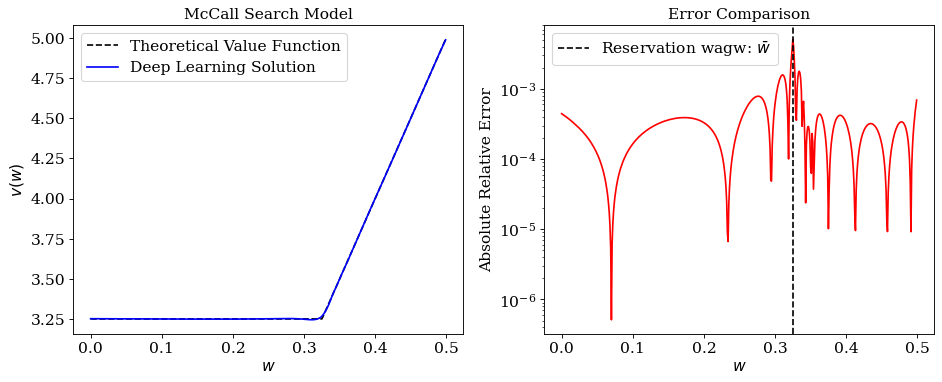

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left plot: value functions ---
axes[0].plot(w_grid_test, v_theory_test, '--', color="k", label='Theoretical Value Function')
axes[0].plot(w_grid_test, v_hat_test, color="b", label='Deep Learning Solution')
axes[0].set_xlabel('$w$')
axes[0].set_ylabel('$v(w)$')
axes[0].set_title("McCall Search Model")
axes[0].legend()
plt.tight_layout()

# --- Right plot: absolute relative error ---
axes[1].plot(w_grid_test, abs_rel_err, color="r")
axes[1].set_xlabel('$w$')
axes[1].set_yscale("log")
axes[1].set_ylabel('Absolute Relative Error')
axes[1].set_title("Error Comparison")
axes[1].axvline(x=w_bar, color="k", linestyle="--", label=r"Reservation wagw: $\bar{w}$")
axes[1].legend()
plt.tight_layout()
plt.show()